In [3]:
import pickle
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import reduce
from collections import defaultdict
import hdbscan 
from sklearn.ensemble import IsolationForest
import seaborn as sns
from math import ceil
from PIL import Image
import umap
import random
from sklearn.cluster import KMeans, MiniBatchKMeans
from functions import *

In [4]:
data_dir = os.path.join("../../../data/embeddings/")
lsoas_file = os.path.join("../../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")

In [5]:
# Two options depending on which semantic categories are being used
file_ending = 'userdefinedclasses' #'planninguseclasses' #userdefinedclasses
categories_dict = {'planninguseclasses':['C – Accommodation', 'B – Industrial / Storage', 'E – Commercial / Business / Service', 
                       'F – Local Community / Learning'],
                  'userdefinedclasses': ['office', 'single_house', 'urban_street', 'shops_and_cafes', 'car',  'park', 
                         'cucumber',  'highway', 'residential_street', 'industrial', 'road']}
headline_categories = categories_dict[file_ending]

### Get spatial data

In [6]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

### Get embeddings (four per location)

In [7]:
points_data_cache = data_dir + f"sample_points_cache/points_data_cache_with_CLIP_embeddings_and_scores_{file_ending}.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [8]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_lsoa, how='inner', predicate='within')
# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


# Find mean embedding at each location.

In [9]:
points_labels_gdf["mean_embedding"] = points_labels_gdf["embedding"].apply(
    lambda emb_list: np.mean(np.stack(emb_list), axis=0)) 
# save
# points_labels_gdf[['LSOA21CD', 'mean_embedding']].to_pickle(data_dir + "embedding_summaries/mean_embeddings_per_location_CLIP.pkl")

# Expand dataframe so there is one row per image

In [10]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embedding']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths
    cat_scores = row['category_scores']        # list of 4 image paths
    
    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embedding, {len(images)} images")
        continue

    for score, emb, img in zip(cat_scores, embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embedding'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        new_row['category_scores'] = score
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)

Skipping row 9158: 3 embedding, 4 images
Skipping row 18664: 3 embedding, 4 images
Original rows: 18897, Expanded rows: 75580


## Assign each image to one classification, based on highest sco

In [19]:
# Flatten all images across all points
all_image_paths = []
all_scores = []

for idx, rec in expanded_gdf.iterrows():
    all_image_paths.extend(rec["image_files"])
    all_scores.append(rec["category_scores"])

# Convert list of arrays → single (N,9) array
all_scores = np.vstack(all_scores)

category_probs = np.array(all_scores)
assigned_labels = category_probs.argmax(axis=1)
assigned_names = [headline_categories[i] for i in assigned_labels]
expanded_gdf['category'] = assigned_names

### Run cluster analysis based on similarity scores

In [26]:
all_embeddings = np.stack(expanded_gdf['category_scores'].values)
best_k, inertias, sil_scores = find_optimal_k_fast(all_embeddings)
print(best_k)

2



Detected elbow at k = 7


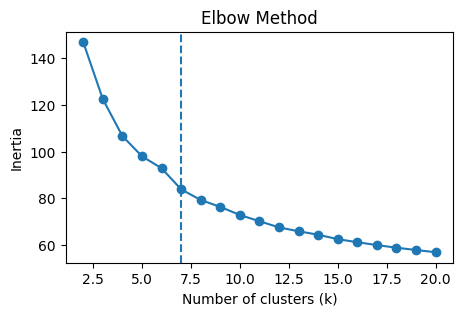

In [27]:
optimal_k, ks, inertias = find_optimal_k_elbow(all_embeddings)
plot_elbow(ks, inertias, optimal_k)

In [28]:
for k in [2,7]:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(all_embeddings)
    expanded_gdf[f'scene_cluster_categoryscores_{k}'] = labels + 1    

2
7


In [30]:
all_embeddings = np.stack(expanded_gdf['embedding'].values)
for k in [2,7]:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(all_embeddings)
    expanded_gdf[f'scene_cluster_{k}'] = labels + 1    

2
7


In [32]:
expanded_gdf[[f'scene_cluster_{k}', f'scene_cluster_categoryscores_{k}']]

,scene_cluster_7,scene_cluster_categoryscores_7
0,5,5
1,4,4
2,7,4
3,1,5
4,6,3
...,...,...
75575,7,4
75576,5,6
75577,1,3
75578,2,6


# Remove inside cars and inside buildings images

In [11]:
# Example wrapper if you have a dataframe
embeddings = np.vstack(expanded_gdf["embedding"].values)   # shape (N, 512)
             # string labels
reducer = umap.UMAP(
    n_neighbors=30, 
    min_dist=0.1, 
    metric='cosine',   # ✔ recommended for CLIP embeddings
    random_state=42)

emb_2d = reducer.fit_transform(embeddings)  # shape (N, 2)

expanded_gdf['umap_x'] = emb_2d[:, 0]
expanded_gdf['umap_y'] = emb_2d[:, 1]

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


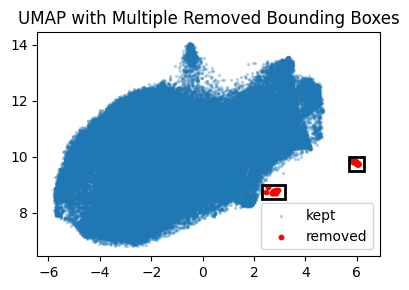

In [12]:
# ---------------------------------------------------------
# 2. Define MULTIPLE bounding boxes
#    Format: (x_min, x_max, y_min, y_max)
# ---------------------------------------------------------
bounding_boxes = [
    (5.7, 6.3, 9.5, 10),     # Box 1
    (2.3, 3.2, 8.5,9)]

# ---------------------------------------------------------
# 3. Build mask for ANY point inside ANY box
# ---------------------------------------------------------
inside_any_box = np.zeros(len(expanded_gdf), dtype=bool)

for (x_min, x_max, y_min, y_max) in bounding_boxes:
    inside_this_box = (
        (expanded_gdf["umap_x"] >= x_min) & (expanded_gdf["umap_x"] <= x_max) &
        (expanded_gdf["umap_y"] >= y_min) & (expanded_gdf["umap_y"] <= y_max))
    inside_any_box |= inside_this_box      # combine masks

# ---------------------------------------------------------
# 4. Remove all points inside any bounding box
# ---------------------------------------------------------
expanded_gdf_filtered = expanded_gdf[~inside_any_box].copy()

# ---------------------------------------------------------
# 5. Visual sanity check
# ---------------------------------------------------------
plt.figure(figsize=(4, 3))

# Points kept
plt.scatter(expanded_gdf_filtered["umap_x"], expanded_gdf_filtered["umap_y"],
            s=2, alpha=0.25, label="kept")

# Points removed
plt.scatter(expanded_gdf.loc[inside_any_box, "umap_x"],
            expanded_gdf.loc[inside_any_box, "umap_y"],
            s=10, color="red", label="removed")

# Draw rectangles on the plot
ax = plt.gca()
for (x_min, x_max, y_min, y_max) in bounding_boxes:
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor="black",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.legend()
plt.title("UMAP with Multiple Removed Bounding Boxes")
plt.tight_layout()
plt.show()

# (Optional) overwrite original:
expanded_gdf = expanded_gdf_filtered.copy()

# Create a dataframe with % of images in each category, in each LSOA 

In [20]:
all_embeddings = np.stack(expanded_gdf['embedding'].values)
df = expanded_gdf
category_column = "category"

In [21]:
# --- 1. Count images per (LSOA, category) ---
category_counts = (df.groupby(["LSOA21CD", category_column]).size().reset_index(name="count"))

# --- 2. Total images per LSOA ---
total_counts = (df.groupby("LSOA21CD").size().reset_index(name="total_images"))

# --- 3. Merge totals ---
category_counts = category_counts.merge(total_counts, on="LSOA21CD")

# --- 4. Add percentage for each category ---
category_counts["pct"] = (category_counts["count"] / category_counts["total_images"] * 100)

# --- 5. Wide table: counts in columns ---
counts_wide = (category_counts.pivot(index="LSOA21CD", columns=category_column, values="count").fillna(0).add_prefix("count_"))

# --- 6. Wide table: percentages in columns ---
pct_wide = (category_counts.pivot(index="LSOA21CD", columns=category_column, values="pct")
        .fillna(0).add_prefix("pct_"))

# --- 7. Combine both + total images per LSOA ---
lsoa_summary = (total_counts.set_index("LSOA21CD").join([counts_wide, pct_wide]))

# plt.hist(lsoa_summary['total_images'], bins=20)

lsoa_summary = lsoa_summary.merge(gm_lsoa['LSOA21CD'],'right', on = "LSOA21CD")
lsoa_summary.head()

,LSOA21CD,total_images,count_car,count_cucumber,count_highway,count_industrial,count_office,count_park,count_residential_street,count_road,...,pct_cucumber,pct_highway,pct_industrial,pct_office,pct_park,pct_residential_street,pct_road,pct_shops_and_cafes,pct_single_house,pct_urban_street
0,E01004766,64.0,0.0,0.0,0.0,2.0,2.0,1.0,33.0,12.0,...,0.0,0.0,3.125000,3.125000,1.562500,51.562500,18.750000,3.125000,18.750000,0.0
1,E01004767,72.0,1.0,0.0,0.0,2.0,2.0,2.0,30.0,17.0,...,0.0,0.0,2.777778,2.777778,2.777778,41.666667,23.611111,1.388889,23.611111,0.0
2,E01004768,44.0,0.0,0.0,0.0,1.0,0.0,0.0,19.0,9.0,...,0.0,0.0,2.272727,0.000000,0.000000,43.181818,20.454545,0.000000,34.090909,0.0
3,E01004769,40.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,16.0,...,0.0,0.0,0.000000,0.000000,2.500000,42.500000,40.000000,0.000000,15.000000,0.0
4,E01004770,40.0,0.0,0.0,0.0,0.0,0.0,2.0,21.0,7.0,...,0.0,0.0,0.000000,0.000000,5.000000,52.500000,17.500000,0.000000,25.000000,0.0


# Spatial plot of percentage in each category

In [356]:
# # merge with LSOA shapes
# plot_gdf = gm_lsoa.merge(category_pct_wide, on="LSOA21CD", how="left").fillna(0)

# # list of categories
# category_names = category_pct_wide.columns.tolist()

# # -------------------------
# # 2. Create subplots
# # -------------------------

# n = len(category_names)
# ncols = 3
# nrows = int(np.ceil(n / ncols))

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5*nrows))
# axs = axs.flatten()

# for ax, category in zip(axs, category_names):
#     plot_gdf.plot(column=category, ax=ax, legend=True, cmap="viridis",
#         edgecolor="black",  linewidth=0.2, legend_kwds={"shrink": 0.5})
#     ax.set_title(f"{category} (%)")
#     ax.axis("off")

# # turn off any empty axes
# for empty_ax in axs[len(category_names):]:
#     empty_ax.axis("off")

# plt.tight_layout()
# plt.show()

# Find mean/median/max embedding in each LSOA, also by catgeory

In [22]:
# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

def max_embed(series):
    return np.max(np.stack(series.values), axis=0)

def median_embed(series):
    return np.median(np.stack(series.values), axis=0)

agg_funcs = {"mean": mean_embed, "max": max_embed, "median": median_embed}

# List of categories
categories = df[category_column].unique()

# Initialize list to hold all DataFrames
all_dfs = []

for agg_name, func in agg_funcs.items():
    dfs = []
    
    # Per-category embeddings
    for cat in categories:
        df_cat = df[df[category_column] == cat]
        emb_cat = df_cat.groupby("LSOA21CD")["embedding"].apply(func).reset_index()
        emb_cat = emb_cat.rename(columns={"embedding": f"{cat}_{agg_name}"})
        dfs.append(emb_cat)
    
    # Merge all categories
    merged = reduce(lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"), dfs)
    
    # Overall embedding (all images in LSOA)
    overall = expanded_gdf.groupby("LSOA21CD")["embedding"].apply(func).reset_index()
    overall = overall.rename(columns={"embedding": f"overall_{agg_name}"})
    
    merged = merged.merge(overall, on="LSOA21CD", how="left")
    
    all_dfs.append(merged)

# Merge mean, max, median into a single DataFrame
from functools import reduce
final_df = reduce(lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"), all_dfs)

###
final_df = final_df.merge(gm_lsoa['LSOA21CD'],'right', on = "LSOA21CD")
# Fill missing embeddings with zeros if needed
final_df = final_df.fillna(0)

# Create one dataframe with all information

In [23]:
final_df = final_df.merge(lsoa_summary, on = "LSOA21CD")
final_df.to_pickle(data_dir + f"embedding_summaries/big_summary_df_CLIP_{file_ending}.pkl")